In [2]:
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path

import librosa
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import iterative_train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
datapath = "/content/drive/MyDrive/AI_sound/5.example/Dataset"
filename = os.listdir(datapath)
filename

['mels_train_curated.pkl', 'train_curated.csv', 'sample_submission.csv']

In [5]:
test_df = pd.read_csv(os.path.join(datapath, filename[2]))
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,426eb1e0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,428d70bb.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4292b1c9.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,429c5071.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
labels = test_df.columns[1:].tolist()
num_classes = len(labels)
num_classes

80

In [7]:
labels

['Accelerating_and_revving_and_vroom',
 'Accordion',
 'Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Bass_guitar',
 'Bathtub_(filling_or_washing)',
 'Bicycle_bell',
 'Burping_and_eructation',
 'Bus',
 'Buzz',
 'Car_passing_by',
 'Cheering',
 'Chewing_and_mastication',
 'Child_speech_and_kid_speaking',
 'Chink_and_clink',
 'Chirp_and_tweet',
 'Church_bell',
 'Clapping',
 'Computer_keyboard',
 'Crackle',
 'Cricket',
 'Crowd',
 'Cupboard_open_or_close',
 'Cutlery_and_silverware',
 'Dishes_and_pots_and_pans',
 'Drawer_open_or_close',
 'Drip',
 'Electric_guitar',
 'Fart',
 'Female_singing',
 'Female_speech_and_woman_speaking',
 'Fill_(with_liquid)',
 'Finger_snapping',
 'Frying_(food)',
 'Gasp',
 'Glockenspiel',
 'Gong',
 'Gurgling',
 'Harmonica',
 'Hi-hat',
 'Hiss',
 'Keys_jangling',
 'Knock',
 'Male_singing',
 'Male_speech_and_man_speaking',
 'Marimba_and_xylophone',
 'Mechanical_fan',
 'Meow',
 'Microwave_oven',
 'Motorcycle',
 'Printer',
 'Purr',
 'Race_car_and_auto_racing',
 

In [8]:
train_curated = pd.read_csv(os.path.join(datapath, filename[1]))
train_curated.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [9]:
with open(os.path.join(datapath, filename[0]), 'rb') as curated:
    x_train = pickle.load(curated)

In [10]:
print(x_train[0].shape)
x_train[0][0]

(128, 448, 3)


array([[ 89,  89,  89],
       [ 94,  94,  94],
       [117, 117, 117],
       ...,
       [127, 127, 127],
       [123, 123, 123],
       [ 87,  87,  87]], dtype=uint8)

In [11]:
import matplotlib.pyplot as plt

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

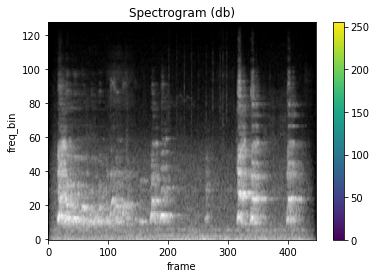

In [12]:
plot_spectrogram(np.transpose(x_train[0],(0,1,2)))

In [13]:
len(x_train), len(train_curated)

(4970, 4970)

In [14]:
idx = labels.index("Bass_drum")
print(idx)

5


In [15]:
y_train = np.zeros((len(train_curated), num_classes)).astype(int)
print(y_train.shape)
for i, row in enumerate(train_curated['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

(4970, 80)


In [16]:
print(y_train[6])

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0]


In [17]:
truth = np.array([1,0,1])
print(truth > 0)
np.flatnonzero(truth > 0)

[ True False  True]


array([0, 2])

In [18]:
x = np.arange(-2, 3)
print(x)
np.flatnonzero(x)

[-2 -1  0  1  2]


array([0, 1, 3, 4])

In [19]:
x = np.arange(6).reshape(2,3)
print(x)
np.flatnonzero(x)

[[0 1 2]
 [3 4 5]]


array([1, 2, 3, 4, 5])

In [20]:
a = np.array([0.3,0.7,0.1])
np.argsort(a)[::-1]

array([1, 0, 2])

In [21]:
a = np.array([1,2,3])
np.cumsum(a)

array([1, 3, 6])

In [22]:
def _one_sample_positive_class_precisions(scores, truth):
    """단일 샘플에 대한 각 실제 클래스의 정밀도를 계산합니다.
    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.
    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # print('pos_class_indices', pos_class_indices)
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    retrieved_classes = np.argsort(scores)[::-1]
    # print('retrieved_classes', retrieved_classes)
    class_rankings = np.zeros(num_classes, dtype=np.int32)
    class_rankings[retrieved_classes] = range(num_classes)
    # print('class_rankings', class_rankings)
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool_)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # print('retrieved_class_true', retrieved_class_true)
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # print('retrieved_cumulative_hits', retrieved_cumulative_hits)
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float32)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    
    return per_class_lwlrap, weight_per_class

In [23]:
_one_sample_positive_class_precisions(np.array([0.1,0.7,0.3]),np.array([1,0,1]))

(array([0, 2]), array([0.66666667, 0.5       ]))

In [24]:
_one_sample_positive_class_precisions(np.array([0.1,0.7,0.3]),np.array([0,1,1]))

(array([1, 2]), array([1., 1.]))

In [25]:
_one_sample_positive_class_precisions(np.array([0.1,0.7,0.3]),np.array([1,1,0]))

(array([0, 1]), array([0.66666667, 1.        ]))

In [26]:
_one_sample_positive_class_precisions(np.array([0.1,0.7,0.3]),np.array([1,0,0]))

(array([0]), array([0.33333333]))

In [27]:
_one_sample_positive_class_precisions(np.array([0.1,0.7,0.3]),np.array([1,1,1]))

(array([0, 1, 2]), array([1., 1., 1.]))

In [28]:
y_true = np.array([[1, 0, 1,], [0, 1, 1]])
y_score = np.array([[0.1, 0.7, 0.3], [0.1, 0.7, 0.3]])
_, precision_at_hits1 = _one_sample_positive_class_precisions(y_score[0], y_true[0])
print("sample 1 Score", precision_at_hits1)
_, precision_at_hits2 = _one_sample_positive_class_precisions(y_score[1], y_true[1])
print("sample 2 Score", precision_at_hits2)
score, weight = calculate_per_class_lwlrap(y_true, y_score)
print("Each class score", score)
print("Weight of each class", weight)
LwLRAP = (score*weight).sum()
print("LwLRAP", LwLRAP)

sample 1 Score [0.66666667 0.5       ]
sample 2 Score [1. 1.]
Each class score [0.66666667 1.         0.75      ]
Weight of each class [0.25 0.25 0.5 ]
LwLRAP 0.7916666666666666


https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html

In [29]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=4)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=4)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=0),
            nn.ELU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=0),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        residual = x
        x = x.permute(0, 3, 1, 2)
        # print(x.shape)           # (64,128,128,3) => (64,3,128,128)
        x = self.conv1(x)
        # print(x.shape)           # (64,3,128,128) w=(8,3,3,3) => (64,8,126,126) => (64,8,31,31)
        x = self.conv2(x)
        # print(x.shape)           # (64,8,31,31) w=(16,8,3,3) => (64,16,29,29) => (64,16,7,7) 
        x = self.conv3(x)
        # print(x.shape)           # (64,16,7,7) w=(64,16,3,3) => (64,64,5,5) 
        x = self.conv4(x)
        # print(x.shape)           # (64,64,5,5) w=(64,64,3,3) => (64,64,3,3) 
        x = F.avg_pool2d(x, 2)
        # print(x.shape)           # (64,64,3,3) stride=2 => (64,64,1,1)
        return x

In [30]:
cb = ConvBlock(in_channels=3, out_channels=64)
print(x_train[0].shape)
a = torch.tensor(x_train[0], dtype=torch.float32)
a = torch.unsqueeze(a,0)
print(a.shape)
out = cb(a[:,:,:128,:])
print(torch.squeeze(out))

(128, 448, 3)
torch.Size([1, 128, 448, 3])
tensor([-0.9955,  1.2885, -1.6784,  0.4901,  0.5207, -0.6833, -2.0163, -0.1773,
        -1.8914, -0.5331,  0.1838, -0.5237, -0.1918, -0.2181,  0.6447, -1.5520,
        -2.3286,  1.9795, -0.4267, -0.6649,  0.2432, -0.3471, -0.4858,  1.7464,
        -1.2565,  2.2511, -0.2534, -0.0816,  2.3117,  0.9519, -1.1446, -0.5987,
        -1.7457, -0.0591,  3.1412,  0.6338,  1.6213,  3.4448, -1.8784,  0.6049,
        -0.6967,  0.5436,  0.1866,  0.8888, -1.6243,  3.0449, -0.2160, -0.1540,
        -2.3100, -1.7606, -0.2272, -0.6492,  0.5564,  0.7516, -1.8856,  1.7620,
        -2.2995, -2.1884,  1.2346, -0.0261,  0.2659, -1.9251,  1.2162,  1.6017],
       grad_fn=<SqueezeBackward0>)


In [31]:
x = torch.tensor([[[[1,2,3],
                    [4,5,6],
                    [7,8,9]]]])
F.avg_pool2d(x, 2, stride=1)  # pool_size=2 , stride=1

tensor([[[[3, 4],
          [6, 7]]]])

In [32]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64, 128),     # (64,64)(64,128)+(128) => (64,128)
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),  # (64,128)(128,80)+(80) => (64,80)
        )

    def forward(self, x):
        x = self.conv(x)               #  (64,64,1,1)
        # print(x.shape)
        x = x.view(x.size(0), -1)      #  (64,64)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x

In [ ]:
a = torch.tensor(x_train[0], dtype=torch.float32)
a = torch.unsqueeze(a,0)
print(a.shape)
cf = Classifier(80)
out = cf(a[:,:,:128,:])
print(out)

In [34]:
layer1 = nn.Linear(64, 128)
layer1(torch.randn(1,64)).shape

torch.Size([1, 128])

In [35]:
class FATTrainDataset(Dataset):
    def __init__(self, mels, labels):
        super().__init__()
        self.mels = mels
        self.labels = labels
        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):
        audio = self.mels[idx]
        audio_clip = audio[:,:128,:]
        label = self.labels[idx]
        label = torch.from_numpy(label).float()
        audio_clip = torch.Tensor(audio_clip)
        
        return audio_clip, label

In [36]:
num_classes = y_train.shape[1]
x_trn, x_val, y_trn, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [37]:
y_val[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
train_dataset = FATTrainDataset(x_trn, y_trn)
valid_dataset = FATTrainDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [39]:
train_dataset[0][0].shape

torch.Size([128, 128, 3])

In [40]:
for  train_i in train_loader:
    print(train_i[0].shape)
    print(train_i[1].shape)
    break

torch.Size([64, 128, 128, 3])
torch.Size([64, 80])


In [78]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 128, 128, 3])
torch.Size([64, 80])


In [42]:
best_epoch = -1
best_lwlrap = 0.
num_epochs = 80
batch_size = 8
test_batch_size = 64
lr = 3e-3

model = Classifier(num_classes=num_classes).cuda()
criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)

In [77]:
from fastprogress import master_bar, progress_bar

mb = master_bar(range(num_epochs))
for epoch in mb:
    start_time = time.time()
    model.train()
    avg_loss = 0.

    for x_batch, y_batch in progress_bar(train_loader, parent=mb):
        preds = model(x_batch.cuda())
        loss = criterion(preds, y_batch.cuda())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)

    model.eval()
    valid_preds = np.zeros((len(x_val), num_classes))
    avg_val_loss = 0.

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        preds = model(x_batch.cuda()).detach()
        loss = criterion(preds, y_batch.cuda())

        preds = torch.sigmoid(preds)
        valid_preds[i * test_batch_size: (i+1) * test_batch_size] = preds.cpu().numpy()

        avg_val_loss += loss.item() / len(valid_loader)
        
    score, weight = calculate_per_class_lwlrap(y_val, valid_preds)
    lwlrap = (score * weight).sum()
    
    if (epoch + 1) % 5 == 0:
        elapsed = time.time() - start_time
        mb.write(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  val_lwlrap: {lwlrap:.6f}  time: {elapsed:.0f}s')

    if lwlrap > best_lwlrap:
        best_epoch = epoch + 1
        best_lwlrap = lwlrap
        torch.save(model.state_dict(), 'weight_best.pt')
        
temp = {
    'best_epoch': best_epoch,
    'best_lwlrap': best_lwlrap,
}

In [95]:
index = 3
x = valid_dataset[index][0]
x = torch.unsqueeze(x, 0)
print(x.shape)

model.eval()

preds = model(x.cuda()).detach()
preds = torch.sigmoid(preds)
preds = preds.argsort(descending=True)
print(preds)

y = valid_dataset[index][1].cuda()
print(y)
y = y.argsort(descending=True)
print(y)

torch.Size([1, 128, 128, 3])
tensor([[13,  3, 23, 18, 17, 71, 19, 43,  4, 64, 66, 78,  8, 10,  0, 33, 54, 75,
         45, 50, 72, 35, 62, 12, 47, 31, 51, 58, 57, 67, 15, 56, 59, 37, 28, 55,
         26, 74, 44, 27, 42,  1,  7, 40, 46, 73,  5,  6, 29,  2, 69, 25, 65, 11,
         79, 61, 20, 16, 22, 41, 63, 30, 39, 76, 70, 14, 48, 53, 32, 52, 49, 21,
         68, 36, 38, 34, 24,  9, 77, 60]], device='cuda:0')
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([ 3, 13, 23,  0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 4

In [116]:
index = 3
x = valid_dataset[index][0]
x = torch.unsqueeze(x, 0)
print(x.shape)

model.eval()
valid_preds = np.zeros((1, num_classes))
preds = model(x.cuda()).detach()
preds = torch.sigmoid(preds)
valid_preds[0:1] = preds.cpu().numpy()
print(valid_preds.shape)

y = y_val[index:index+1]
print(y.shape)

score, weight = calculate_per_class_lwlrap(y, valid_preds)
lwlrap = (score * weight).sum()
print(lwlrap)

torch.Size([1, 128, 128, 3])
(1, 80)
(1, 80)
1.0
